In [1]:
!pip install ccxt

In [2]:
import asyncio
import json
import pandas as pd
import matplotlib.pyplot as plt
import ccxt.async_support as ccxt

In [3]:
async def test_get_kline_data(exchange:str, symbol:str, interval:str, size:int, start:int=None, end:int=None):
    exchanges = {
        'upbit' : {
            'url' : 'https://api.upbit.com/v1/candles/{}{}?market={}&count={}',
            'path_params' : ['minutes', 'days', 'weeks', 'months'],
            'query_params' : ['market', 'count'],
            'limit' : 200,
            'interval_enum' : [1,3,5,10,15,30,60,240]
        },
        'bithumb' : {
            'url' : 'https://api.bithumb.com/v1/candles/{}{}?market={}&count={}',
            'path_params' : ['minutes', 'days', 'weeks', 'months'],
            'query_params' : ['market', 'count'],
            'limit' : 200,
            'interval_enum' : [1,3,5,10,15,30,60,240]
        },
        'coinone' : {
            'url' : 'https://api.coinone.co.kr/public/v2/chart/KRW/{}?interval={}&size={}',
            'path_params' : ['target_currency'],
            'query_params' : ['interval', 'size'],
            'limit' : 500,
            'interval_enum' : ['1m', '3m', '5m', '10m', '15m', '30m', '1h', '2h', '4h', '6h', '1d', '1w', '1mon']
        },
        'korbit' : {
            'url' : 'https://api.korbit.co.kr/v2/candles?symbol={}&interval={}&limit={}',
            'query_params' : ['symbol', 'interval', 'limit'],
            'limit' : 200,
            'interval_enum' : [1,5,15,30,60,240,'1D','1W']
        },
        'bybit' : {
            'url' : 'https://api.bybit.com/v5/market/kline?category=linear&symbol={}&interval={}&limit={}',
            'query_params' : ['category', 'symbol', 'interval', 'limit'],
            'limit' : 1000,
            'interval_enum' : [1,3,5,15,30,60,120,240,360,720,'D','W','M']
        },
        'binance' : {
            'url' : 'https://fapi.binance.com/fapi/v1/klines?symbol={}&interval={}&limit={}',
            'query_params' : ['symbol', 'interval', 'limit'],
            'limit' : 1500,
            'interval_enum' : ['1m', '3m', '5m', '15m', '30m', '1h', '2h', '4h', '6h', '8h', '12h', '1d', '1w', '1M']
        },
        'okx' : {
            'url' : 'https://www.okx.com/api/v5/market/mark-price-candles?instId={}&bar={}&limit={}',
            'query_params' : ['instId', 'bar', 'limit'],
            'limit' : 100,
            'interval_enum' : ['1m', '3m', '5m', '15m', '30m', '1H', '2H', '4H', '6H', '12H', '1D', '1W', '1M']
        },
        'bitget' : {
            'url' : 'https://api.bitget.com/api/v2/mix/market/candles?symbol={}&granularity={}&limit={}&productType=usdt-futures',
            'query_params' : ['symbol', 'granularity', 'limit', 'productType'],
            'limit' : 1000,
            'interval_enum' : ['1m', '3m', '5m', '15m', '30m', '1H', '2H', '4H', '6H', '12H', '1D', '1W', '1M']
        },
        'gateio' : {
            'url' : 'https://api.gateio.ws/api/v4/futures/usdt/candlesticks?contract={}&interval={}&limit={}',
            'query_params' : ['symbol', 'interval', 'limit'],
            'limit' : 2000,
            'interval_enum' : ['1m', '3m', '5m', '15m', '30m', '1h', '2h', '4h', '6h', '8h', '12h', '1d', '1w']
        }
    }

    spec = exchanges[exchange]

    import aiohttp

    async def aiocurl(url):
        async with aiohttp.ClientSession() as session:
            async with session.get(url) as response:
                if response.status == 200:
                    return await response.text()
                else:
                    print(f'Error: {response.status}')
                    return None
    
    query_string = spec['url']
    args = []
    interval = str(interval).lower()

    if exchange in ['upbit', 'bithumb', 'coinone', 'korbit']:
        print(f'exchange: {exchange} is Korean Exchange')

        if exchange in ['upbit', 'bithumb']:
            if interval[-1] == 'h':
                args.append('minutes')
                interval = int(interval[:-1]) * 60

                if interval not in spec['interval_enum']:
                    raise ValueError

                args.append('/' + str(interval))

            elif interval[-1] == 'm':
                args.append('minutes')

                if int(interval[:-1]) not in spec['interval_enum']:
                    raise ValueError

                args.append('/' + interval[:-1])

            elif interval[-1] == 'd':
                args.append('days')
                args.append('')

            elif interval[-1] == 'w':  
                args.append('weeks')
                args.append('')
            
            symbol = 'KRW-' + symbol
            args.append(symbol)
        
        elif exchange == 'korbit':
            if interval[-1] == 'h':
                interval = int(interval[:-1]) * 60

                if interval not in spec['interval_enum']:
                    raise ValueError

            elif interval[-1] == 'm':
                interval = int(interval[:-1])

                if interval not in spec['interval_enum']:
                    raise ValueError
                
            elif interval[-1] == 'd':
                if interval != '1d':
                    raise ValueError
                interval = '1D'
                
            elif interval[-1] == 'w':
                if interval != '1w':
                    raise ValueError
                interval = '1W'

            symbol = symbol.lower() + '_krw'
            args.append(symbol)
            args.append(interval)

        elif exchange == 'coinone':
            if interval not in spec['interval_enum']:
                raise ValueError

            args.append(symbol)
            args.append(interval)

    elif exchange in ['bybit', 'binance', 'okx', 'bitget', 'gateio']:
        print(f'exchange: {exchange} is Global Exchange')

        if exchange == 'binance':
            if interval not in spec['interval_enum']:
                raise ValueError

            symbol += 'USDT'

        if exchange == 'bybit':
            if interval[-1] in ['d', 'w']:
                interval = interval[-1].upper()
            elif interval[-1] == 'h':
                interval = int(interval[:-1]) * 60
            elif interval[-1] == 'm':
                interval = int(interval[:-1])

            if interval not in spec['interval_enum']:
                raise ValueError
            
            symbol += 'USDT'
            
        if exchange == 'bitget':
            if interval[-1] in ['d', 'w', 'h']:
                interval = interval.upper()
            
            if interval not in spec['interval_enum']:
                raise ValueError
            
            symbol += 'USDT'
            
        if exchange == 'okx':
            if interval[-1] in ['d', 'w', 'h']:
                interval = interval.upper()

            if interval not in spec['interval_enum']:
                raise ValueError
            
            symbol += '-USDT-SWAP'

        if exchange == 'gateio':
            if interval not in spec['interval_enum']:
                raise ValueError
            
            symbol += '_USDT'

        args.append(symbol)
        args.append(interval)

    args.append(spec['limit'] if size == None else size)

    query_string = spec['url'].format(*args)

    if start != None and end != None:
        query_string += f'&start={start}&end={end}'

    print(query_string)

    result = await aiocurl(query_string)
    result = json.loads(result)

    # if isinstance(result, dict):
    #     print(len(result))
    #     print(result.keys())
    # elif isinstance(result, list):
    #     print(len(result))

    if exchange == 'coinone':
        result = result['chart']
    elif exchange == 'bybit':
        result = result['result']['list']
    elif exchange in ['bitget', 'okx', 'korbit']:
        result = result['data']

    # print(json.dumps(result, indent=4))
    return result

In [4]:
result = await test_get_kline_data('bybit', 'BTC', '1m', None)
df = pd.DataFrame(result, columns=['timestamp', 'open', 'high', 'low', 'close', 'target_volume', 'quote_volume'])
df['datetime'] = pd.to_datetime(df.timestamp, unit='ms')
df.iloc[0]

exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=BTCUSDT&interval=1&limit=1000


/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_50826/2369243745.py:3: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['datetime'] = pd.to_datetime(df.timestamp, unit='ms')


timestamp              1730737560000
open                         68333.8
high                         68338.1
low                          68333.8
close                        68338.1
target_volume                  0.297
quote_volume              20295.8368
datetime         2024-11-04 16:26:00
Name: 0, dtype: object

In [ ]:
raw_data = await test_get_kline_data('gateio', 'BTC', '15m', None)
df2 = pd.DataFrame(raw_data, columns=['t', 'v', 'c', 'h', 'l', 'o', 'sum'])
df2['datetime'] = pd.to_datetime(df2['t'], unit='s')
df2.datetime = df2.datetime.dt.tz_localize('UTC').dt.tz_convert('Asia/Seoul')
df2.sort_values('datetime', inplace=True, ascending=False)
df2

exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/minutes/15?market=KRW-STG&count=200
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=STGUSDT&interval=15&limit=1000
exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/minutes/15?market=KRW-USDT&count=200


/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_50826/3953043452.py:83: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')


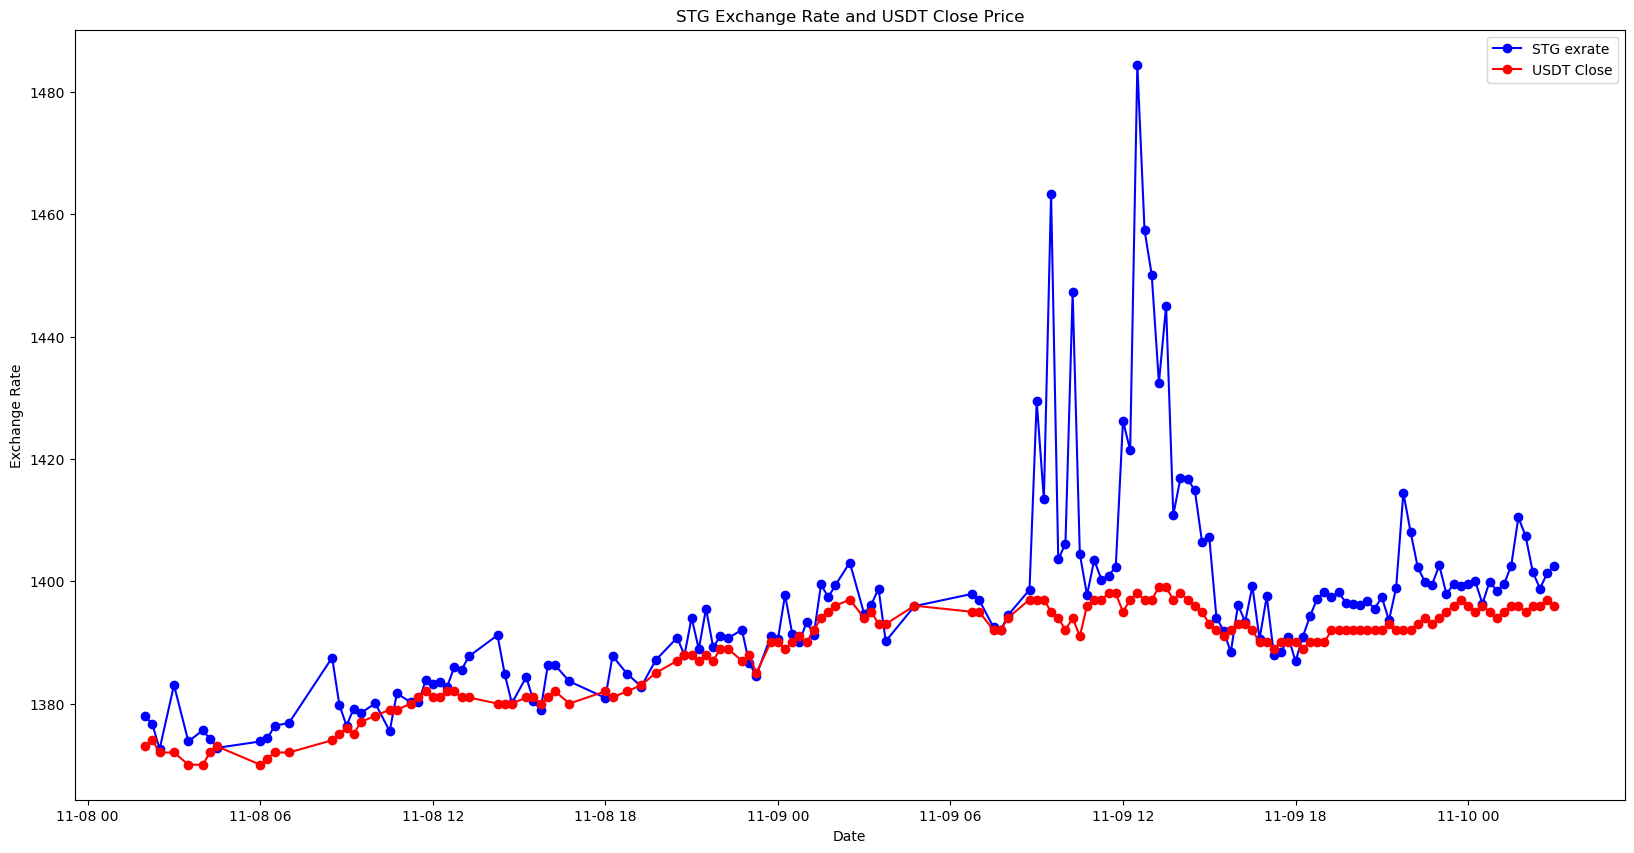

In [193]:
async def test_get_kimp_kline_data(symbol:str, ex1:str, ex2:str, interval:str, size:int):
    '''

    '''
    # interval validation check
    # bithumb 4h interval disallowed
    if ex1 == 'bithumb' and (interval == '4h' or interval == '1d' or interval == '1w'):
        raise ValueError(f'can compare {interval} interval of bithumb data to others')

    krw_task = test_get_kline_data(ex1, symbol, interval, size)
    usdt_task = test_get_kline_data(ex2, symbol, interval, size)
    tether_task = test_get_kline_data('upbit', 'USDT', interval, size)

    krw_raw_data, usdt_raw_data, tether_raw_data = await asyncio.gather(krw_task, usdt_task, tether_task)

    ex_col_map = {
        'upbit' : ['opening_price', 'high_price', 'low_price', 'trade_price', 'candle_acc_trade_volume', 'candle_acc_trade_price'],
        'bithumb' : ['opening_price', 'high_price', 'low_price', 'trade_price', 'candle_acc_trade_volume', 'candle_acc_trade_price'],
        'coinone' : ['open', 'high', 'low', 'close', 'target_volume', 'quote_volume'],
        'korbit' : ['open', 'high', 'low', 'close', 'volume'],
        'bybit' : ['timestamp', 'open', 'high', 'low', 'close', 'target_volume', 'quote_volume'],
        'bitget' : ['timestamp', 'open', 'high', 'low', 'close', 'target_volume', 'quote_volume'],
        'binance' : ['timestamp', 'open', 'high', 'low', 'close', 'target_volume', 'close_time', 'quote_volume', 'Number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'],
        'okx' : ['timestamp', 'open', 'high', 'low', 'close', 'confirm'],
        'gateio' : ['t', 'v', 'c', 'h', 'l', 'o', 'sum']
    }

    ex_datetime_col_map = {
        'upbit' : 'candle_date_time_kst',
        'bithumb' : 'candle_date_time_kst',
        'coinone' : 'timestamp',
        'korbit' : 'timestamp',
        'bybit' : 'timestamp',
        'bitget' : 'timestamp',
        'binance' : 'timestamp',
        'okx' : 'timestamp',
        'gateio' : 't'
    }

    cols_to_convert = ['datetime', 'open', 'high', 'low', 'close', 'target_volume', 'quote_volume']

    krw_df = pd.DataFrame(krw_raw_data)

    if ex1 in ['upbit', 'bithumb']:
        krw_df.rename(columns={'candle_date_time_kst' : 'datetime'}, inplace=True)
        krw_df.datetime = pd.to_datetime(krw_df.datetime)
        krw_df.datetime = krw_df.datetime.dt.tz_localize('Asia/Seoul')

    elif ex1 == 'coinone':
        krw_df['datetime'] = pd.to_datetime(krw_df.timestamp, unit='ms')
        krw_df.datetime = krw_df.datetime.dt.tz_localize('UTC').dt.tz_convert('Asia/Seoul')

    elif ex1 == 'korbit':
        krw_df['datetime'] = pd.to_datetime(krw_df.timestamp, unit='ms')
        krw_df.datetime = krw_df.datetime.dt.tz_localize('UTC').dt.tz_convert('Asia/Seoul')
        krw_df.datetime = krw_df.datetime - pd.Timedelta(hours=3)
        krw_df.sort_values('datetime', inplace=True, ascending=False)

    krw_df[ex_col_map[ex1]] = krw_df[ex_col_map[ex1]].apply(pd.to_numeric)
    krw_df = krw_df[['datetime'] + ex_col_map[ex1]]

    if ex1 == 'korbit':
        cols_to_convert = ['datetime', 'open', 'high', 'low', 'close', 'volume']
    krw_df.columns = cols_to_convert

    # print(krw_df.loc[krw_df.datetime.dt.date == pd.to_datetime('2024-10-11').date()])

    usdt_df = pd.DataFrame(usdt_raw_data, columns=ex_col_map[ex2])

    if ex2 == 'gateio':
        usdt_df.rename(columns={'t' : 'timestamp', 'o' : 'open', 'h' : 'high', 'l' : 'low', 'c' : 'close', 'v' : 'target_volume', 'sum' : 'quote_volume'}, inplace=True)
    
    filtered_cols = ['timestamp', 'open', 'high', 'low', 'close', 'target_volume', 'quote_volume']

    if ex2 == 'okx':
        filtered_cols = ['timestamp', 'open', 'high', 'low', 'close']

    usdt_df = usdt_df[filtered_cols]

    if ex2 == 'gateio':
        usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='s')
    else:
        usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')

    usdt_df.datetime = usdt_df.datetime.dt.tz_localize('UTC').dt.tz_convert('Asia/Seoul')
    usdt_df[filtered_cols] = usdt_df[filtered_cols].apply(pd.to_numeric)

    tether_df = pd.DataFrame(tether_raw_data)
    tether_df.rename(columns={'candle_date_time_kst' : 'datetime'}, inplace=True)
    tether_df.datetime = pd.to_datetime(tether_df.datetime)
    tether_df.datetime = tether_df.datetime.dt.tz_localize('Asia/Seoul')
    tether_df[ex_col_map['upbit']] = tether_df[ex_col_map['upbit']].apply(pd.to_numeric)
    tether_df = tether_df[['datetime'] + ex_col_map['upbit']]
    tether_df.columns = cols_to_convert

    # print(usdt_df.loc[usdt_df.datetime.dt.date == pd.to_datetime('2024-10-11').date(), ['datetime', 'open', 'high', 'low', 'close']]) 

    merged_df = pd.merge(krw_df, usdt_df, on='datetime', how='inner')
    merged_df['exrate'] = merged_df.apply(lambda row: round(max(row['high_x'] / row['high_y'], row['low_x'] / row['low_y']), 3), axis=1)
    merged_df = pd.merge(merged_df, tether_df, on='datetime', how='inner')
    merged_df.rename(columns={'close' : 'usdt_close'}, inplace=True)
    merged_df['kimp'] = (merged_df.exrate - merged_df.usdt_close) / merged_df.usdt_close * 100

    # merged_df.datetime = merged_df.datetime.dt.tz_localize('UTC').dt.tz_convert('Asia/Seoul')
    # lower_quantile = merged_df.spread.quantile(0.25)
    # higher_quantile = merged_df.spread.quantile(0.75)

    # print(merged_df.loc[merged_df.datetime.dt.date == pd.to_datetime('2024-10-21').date(), ['datetime', 'close_x', 'close_y', 'kimp']])

    return {
        'symbol' : symbol,
        'data' : merged_df[['datetime', 'close_x', 'close_y', 'exrate', 'kimp', 'usdt_close']],
        # 'lower_quantile' : lower_quantile,
        # 'higher_quantile' : higher_quantile
    }
result = await test_get_kimp_kline_data('STG', 'bithumb', 'bybit', '15m', None)
result['data']

# Plotting the data
fig, ax = plt.subplots(figsize=(20, 10))
# ax2 = ax.twinx()
ax.plot(result['data'].datetime, result['data'].exrate, label=f'{result['symbol']} exrate', color='blue', marker='o')
ax.plot(result['data'].datetime, result['data'].usdt_close, label='USDT Close', color='red', marker='o')

# # Add horizontal lines and their values as annotations
# ax.axhline(0, color='black', linewidth=1)
# ax.axhline(result['lower_quantile'], color='red', linestyle='--', linewidth=1)
# ax.axhline(result['higher_quantile'], color='red', linestyle='--', linewidth=1)

# # Adding the quantile values as text on the y-axis
# ax.text(result['data'].datetime.iloc[-1], result['lower_quantile'], f"{result['lower_quantile']:.2f}", 
#         color='red', verticalalignment='bottom', horizontalalignment='left')
# ax.text(result['data'].datetime.iloc[-1], result['higher_quantile'], f"{result['higher_quantile']:.2f}", 
#         color='red', verticalalignment='bottom', horizontalalignment='left')

# Additional plot settings
ax.set_title(f'{result["symbol"]} Exchange Rate and USDT Close Price')
ax.set_xlabel('Date')
ax.set_ylabel('Exchange Rate')
ax.legend()
# ax2.legend(loc='upper left')
plt.show()

In [173]:
df = await test_fetch_all_tickers(['upbit', 'coinone', 'bithumb', 'binance', 'bybit', 'okx', 'bitget', 'gateio'])

rows = df.iterrows()

import itertools
ret = []
symbols = []
lower_quantiles = []
while True:
    batch = list(itertools.islice(rows, 5))

    if not batch:
        break

    tasks = [test_calculate_kimp_historical_data(i.symbol, i.exchange_x, i.exchange_y, '1d') for _, i in batch]
    results = await asyncio.gather(*tasks)

    for r in results:
        ret.append(r)
        symbols.append(r['symbol'])
        lower_quantiles.append(r['lower_quantile'])

ret_df = pd.DataFrame({'symbol': symbols, 'lower_quantile': lower_quantiles})
ret_df

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/944895524.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, tmp_df])


exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/NFP?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=NFPUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/RON?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=RONUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/ORCA?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ORCAUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/PHA?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=PHAUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/pub

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/DODO?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=DODOUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/COS?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=COSUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/FORTH?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=FORTHUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/ONG?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ONGUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/BNT?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=BNTUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/MOCA?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=MOCAUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/JST?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=JSTUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/WAVES?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=WAVESUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/SXP?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=SXPUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/CLOUD?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=CLOUDUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/REZ?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=REZUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/CATI?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=CATIUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/KNC?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=KNCUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/DYDX?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=DYDXUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/ATH?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ATHUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/FXS?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=FXSUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/pub

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/AAVE?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=AAVEUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/STRK?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=STRKUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-CRO&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=CROUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/DBR?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=DBRUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candle

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/NTRN?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=NTRNUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/VET?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=VETUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/BAL?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=BALUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/QTUM?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=QTUMUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-C98&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=C98USDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-XLM&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=XLMUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-RVN&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=RVNUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-IOTX&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=IOTXUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/CTSI?in

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')


exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/AEVO?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=AEVOUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/BSV?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=BSVUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/SNX?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=SNXUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/SUNDOG?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=SUNDOGUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/MTL?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=MTLUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/KAS?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=KASUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/BEAM?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=BEAMUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-BAT&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=BATUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-HIGH&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=HIGHUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-NMR&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=NMRUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/STG?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=STGUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/BLAST?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=BLASTUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/c

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-XVS&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=XVSUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/CKB?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=CKBUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/SUI?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=SUIUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-LSK&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=LSKUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/K

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-AVAIL&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=AVAILUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-ANKR&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ANKRUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-ZK&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ZKUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-ONT&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ONTUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-KAVA&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=KAVAUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/LINK?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=LINKUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-MANA&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=MANAUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/IO?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=IOUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/IMX?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=IMXUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/GMT?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=GMTUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/ICP?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ICPUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-CORE&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=COREUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/SNT?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=SNTUSDT&interval=D&limit=500
exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KRW-ICX&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ICXUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/HBAR?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=HBARUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/PYTH?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=PYTHUSDT&interval=D&limit=500
exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?m

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-GMX&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=GMXUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-GRT&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=GRTUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-COTI&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=COTIUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-FTM&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=FTMUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-AP

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-ETHFI&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ETHFIUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-CTK&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=CTKUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-FLOW&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=FLOWUSDT&interval=D&limit=500
exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KRW-MINA&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=MINAUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/LQTY?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=LQTYUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-ILV&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ILVUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-STMX&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=STMXUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/IOST?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=IOSTUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/c

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/ZETA?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ZETAUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-KSM&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=KSMUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-W&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=WUSDT&interval=D&limit=500
exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KRW-AUCTION&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=AUCTIONUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-FLUX&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=FLUXUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-BNB&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=BNBUSDT&interval=D&limit=500
exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KRW-UXLINK&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=UXLINKUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-SUN&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=SUNUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/BCH?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=BCHUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/KLAY?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=KLAYUSDT&interval=D&limit=500
exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KRW-HIFI&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=HIFIUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-GLM&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=GLMUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?mar

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-CHZ&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=CHZUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-WAXP&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=WAXPUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-FITFI&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=FITFIUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/DOT?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=DOTUSDT&interval=D&limit=500
exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')


exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-AUDIO&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=AUDIOUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/ZRX?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ZRXUSDT&interval=D&limit=500
exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KRW-IOTA&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=IOTAUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-XRP&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=XRPUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/M

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-FIDA&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=FIDAUSDT&interval=D&limit=500
exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KRW-ID&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=IDUSDT&interval=D&limit=500
exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KRW-SEI&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=SEIUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/ETC?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ETCUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/JUP?interva

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/OP?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=OPUSDT&interval=D&limit=500
exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KRW-POL&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=POLUSDT&interval=D&limit=500
exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KRW-ZRO&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ZROUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-PYR&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=PYRUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-JOE&coun

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-BEL&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=BELUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/ZIL?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ZILUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-CRV&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=CRVUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-ALICE&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ALICEUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-NEO&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=NEOUSDT&interval=D&limit=500
exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KRW-STORJ&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=STORJUSDT&interval=D&limit=500
exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KRW-SOL&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=SOLUSDT&interval=D&limit=500
exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KRW-PENDLE&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=PENDLEUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-MNT&co

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KRW-STX&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=STXUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-ZBCN&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ZBCNUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-XCN&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=XCNUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-APE&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=APEUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-CAKE&c

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-RLC&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=RLCUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-ENS&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ENSUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-UMA&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=UMAUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-API3&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=API3USDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-MA

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-ACE&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ACEUSDT&interval=D&limit=500
exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KRW-ADA&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ADAUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-STPT&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=STPTUSDT&interval=D&limit=500
exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KRW-POWR&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=POWRUSDT&interval=D&limit=500
exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KRW-ETH&count=50

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KRW-BTC&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=BTCUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/TNSR?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=TNSRUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/BOME?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=BOMEUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-XTZ&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=XTZUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/K

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-AVAX&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=AVAXUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/ONDO?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ONDOUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-EDU&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=EDUUSDT&interval=D&limit=500
exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KRW-EOS&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=EOSUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/LIS

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/EIGEN?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=EIGENUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-OSMO&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=OSMOUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-HOOK&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=HOOKUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/USDC?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=USDCUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KRW-ORBS&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ORBSUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-STEEM&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=STEEMUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/ARB?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ARBUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-ARKM&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ARKMUSDT&interval=D&limit=500
exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KR

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')


exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/MANTA?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=MANTAUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/DOGE?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=DOGEUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-SFP&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=SFPUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-RAD&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=RADUSDT&interval=D&limit=500
exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?m

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KRW-SC&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=SCUSDT&interval=D&limit=500
exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KRW-ASTR&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ASTRUSDT&interval=D&limit=500
exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KRW-CVC&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=CVCUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-ACH&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ACHUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/WLD?interval=1d&size=

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-ATOM&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ATOMUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/TRX?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=TRXUSDT&interval=D&limit=500
exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KRW-1INCH&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=1INCHUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-CELR&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=CELRUSDT&interval=D&limit=500
exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KR

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')


exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-TAIKO&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=TAIKOUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-JTO&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=JTOUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-RENDER&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=RENDERUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-WOO&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=WOOUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/MKR?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=MKRUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-XAI&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=XAIUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-AR&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ARUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/TON?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=TONUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?marke

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-CHR&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=CHRUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-LDO&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=LDOUSDT&interval=D&limit=500
exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KRW-ARK&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ARKUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-AIOZ&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=AIOZUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-SUSHI&

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-RSS3&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=RSS3USDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-BRETT&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=BRETTUSDT&interval=D&limit=500
exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KRW-CTC&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=CTCUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-OXT&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=OXTUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-AE

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-BOBA&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=BOBAUSDT&interval=D&limit=500
exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KRW-CARV&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=CARVUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/T?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=TUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-LRC&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=LRCUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-GT

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-DAR&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=DARUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-AGI&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=AGIUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-LEVER&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=LEVERUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-CFX&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=CFXUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/ALPHA

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/MAVIA?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=MAVIAUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-REQ&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=REQUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-ARPA&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ARPAUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/PIXEL?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=PIXELUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/PRCL?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=PRCLUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-FLR&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=FLRUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/AERO?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=AEROUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/SKL?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=SKLUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/TWT?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=TWTUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/BAND?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=BANDUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/ZEUS?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ZEUSUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/PROM?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=PROMUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/MYRO?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=MYROUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/ALT?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ALTUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/ORDER?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=ORDERUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/MON?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=MONUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/HOT?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=HOTUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/PAXG?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=PAXGUSDT&interval=D&limit=500
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-RDNT&count=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=RDNTUSDT&interval=D&limit=500
exchange: coinone is Korean Exchange
https://api.coinone.co.kr/public/v2/chart/KRW/CETUS?interval=1d&size=500
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=CETUSUSDT&interval=D&limit=500


/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_31608/3573831935.py:78: FutureWarni

,symbol,lower_quantile
0,NFP,571.073246
1,RON,1373.212417
2,ORCA,1345.844404
3,PHA,1322.748983
4,PRIME,1576.868770
...,...,...
249,SCA,1338.614776
250,HOT,1343.352123
251,PAXG,1343.514329
252,RDNT,NaN


exchange: upbit is Korean Exchange
https://api.upbit.com/v1/candles/days?market=KRW-XRP&count=200
exchange: bybit is Global Exchange
https://api.bybit.com/v5/market/kline?category=linear&symbol=XRPUSDT&interval=D&limit=1000
exchange: bithumb is Korean Exchange
https://api.bithumb.com/v1/candles/days?market=KRW-USDT&count=200


/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_36270/3093252586.py:78: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')


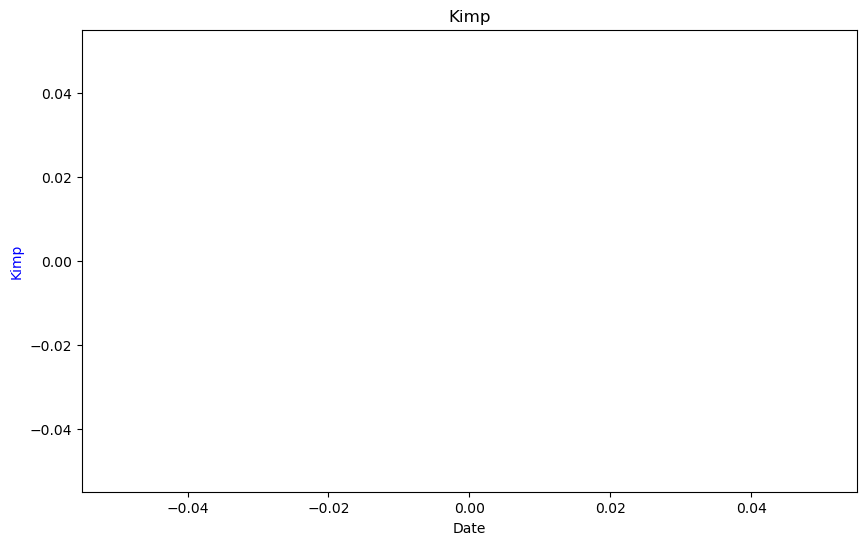

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


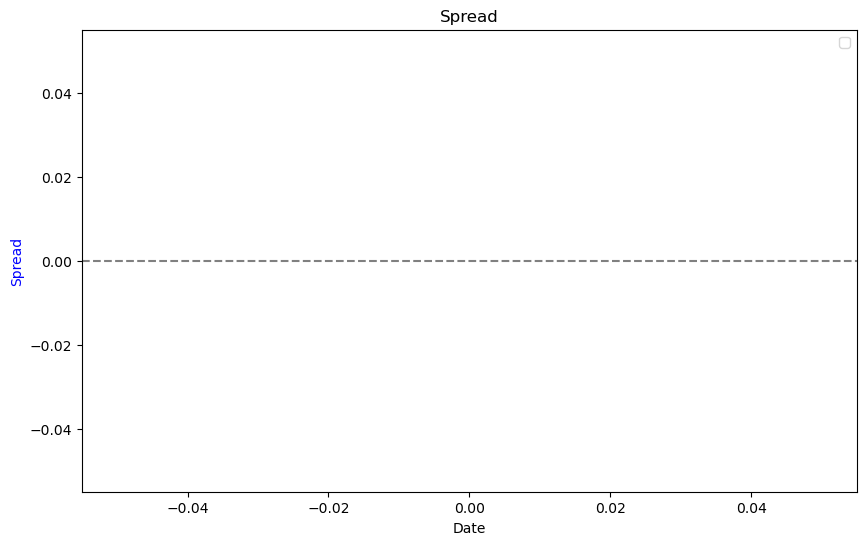

In [97]:
result = await test_get_kimp_kline_data('XRP', 'upbit', 'bybit', '1d', None)

import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))
p = sns.lineplot(x='datetime', y='kimp', data=result['data'], color='b')
p.set_ylabel('Kimp', color='b')
ax.set_xlabel('Date')
ax.set_title('Kimp')

plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
# Plot 'kimp' on the primary Y-axis
sns.lineplot(x='datetime', y='spread', data=result['data'], color='b', ax=ax, marker='o')
# Set labels and title
ax.set_ylabel('Spread', color='b')
ax.set_xlabel('Date')
ax.set_title('Spread')

# Add a horizontal line at y=0
plt.axhline(0, color='gray', linestyle='--')

# Display a legend to differentiate the lines
ax.legend()

plt.show()

In [27]:
async def fetch_orderbook(exchange, symbol, quote, future=False):
    target = symbol + '/' + quote
    if future:
        target += ':' + quote
    try:
        return await exchange.fetch_order_book(target)
    except Exception as e:
        print(f"Error fetching orderbook for {target} on {exchange.id}: {e}")
        return None

In [28]:
def calculate_market_order_amount(orderbook, seed, is_buy, fee_rate):
    price_level = orderbook['asks'] if is_buy else orderbook['bids']

    if is_buy:
        # Reduce seed money by the fee
        effective_money = seed * (1 - fee_rate)
        total_fee = seed * fee_rate
        total_bought_coin = 0
        remaining_money = effective_money

        try:
            if len(price_level[0]) == 2:
                # Iterate through the ask prices and calculate the amount of coins you can buy
                for price, volume in price_level:
                    if remaining_money >= price * volume:
                        total_bought_coin += volume
                        remaining_money -= price * volume
                    else:
                        total_bought_coin += remaining_money / price
                        break
            elif len(price_level[0]) == 3:
                for price, volume, _ in price_level:
                    if remaining_money >= price * volume:
                        total_bought_coin += volume
                        remaining_money -= price * volume
                    else:
                        total_bought_coin += remaining_money / price
                        break
            else:
                raise ValueError
        except Exception as e:
            print(price_level)
            raise e

        return total_bought_coin, total_fee

    else:
        total_revenue = 0
        remaining_coins = seed

        # Iterate through the bids to calculate revenue
        try:
            if len(price_level[0]) == 2:
                for price, volume in price_level:
                    if remaining_coins >= volume:
                        total_revenue += price * volume
                        remaining_coins -= volume
                    else:
                        total_revenue += price * remaining_coins
                        break
            elif len(price_level[0]) == 3:
                for price, volume, _ in price_level:
                    if remaining_coins >= volume:
                        total_revenue += price * volume
                        remaining_coins -= volume
                    else:
                        total_revenue += price * remaining_coins
                        break
            else:
                raise ValueError
        except Exception as e:
            print(price_level)
            raise e

        # Reduce revenue by the selling fee
        return total_revenue * (1 - fee_rate), total_revenue * fee_rate

In [ ]:
async def fetch_ticker(symbol:str):
    import requests

    url = f"https://api.bithumb.com/v1/ticker?markets={symbol}"

    headers = {"accept": "application/json"}

    response = requests.get(url, headers=headers)

    return response.json()

result = await fetch_ticker("KRW-USDT")
result

In [30]:
import ccxt.async_support as ccxt

async def test_fetch_all_tickers(exchanges):
    tasks = []
    ex_list = []
    for ex in exchanges:
        exchange_class = getattr(ccxt, ex)
        exchange = exchange_class()
        ex_list.append(exchange)

        tasks.append(exchange.fetch_tickers())

    results = await asyncio.gather(*tasks)

    columns = ['exchange', 'symbol', 'quote', 'price']

    df = pd.DataFrame(columns=columns)

    for result, ex in zip(results, exchanges):
        data = {
            'symbol' : [],
            'quote' : [],
            'price' : [],
            'spotOrfuture' : []
        }
        for key, val in result.items():
            if not isinstance(val['last'], int) and not isinstance(val['last'], float):
                continue

            quote = key.split('/')[1]
            if ':' in key.split('/')[1]:
                quote = quote.split(':')[0]
                data['spotOrfuture'] = 'future'
            else:
                data['spotOrfuture'] = 'spot'

            data['symbol'].append(key.split('/')[0])
            data['quote'].append(quote)
            data['price'].append(val['last'])
        
        tmp_df = pd.DataFrame(data)
        tmp_df['exchange'] = ex

        df = pd.concat([df, tmp_df])

    df.reset_index(drop=True, inplace=True)

    spot_df = df.loc[(df.spotOrfuture == 'spot') & (df.quote == 'KRW')]
    spot_df2 = spot_df.groupby('symbol').agg(
        min_price=('price', 'min'),
        min_idx=('price', 'idxmin')
    ).reset_index()

    spot_df2['exchange'] = spot_df2.min_idx.map(spot_df.exchange)
    final_spot_df = spot_df2.drop(columns=['min_idx'])

    future_df = df.loc[(df.spotOrfuture == 'future') * (df.quote == 'USDT')]
    future_df2 = future_df.groupby('symbol').agg(
        max_price=('price', 'max'),
        max_idx=('price', 'idxmax')
    ).reset_index()

    future_df2['exchange'] = future_df2.max_idx.map(future_df.exchange)
    final_future_df = future_df2.drop(columns=['max_idx'])

    merged_df = pd.merge(final_spot_df, final_future_df, on='symbol', how='inner')
    merged_df['kimchipremium'] = round(merged_df.min_price / merged_df.max_price, 4)
    merged_df.sort_values('kimchipremium', inplace=True)

    for ex in ex_list:
        await ex.close()

    return merged_df

In [31]:
result = await test_fetch_all_tickers(['upbit', 'coinone', 'bithumb', 'binance', 'bybit', 'okx', 'bitget', 'gateio'])
result

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_36270/944895524.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, tmp_df])


,symbol,min_price,exchange_x,max_price,exchange_y,kimchipremium
161,NFP,119.10,coinone,0.21540,bybit,552.9248
170,ORCA,2925.00,coinone,2.26300,bybit,1292.5320
74,DATA,49.39,coinone,0.03787,bybit,1304.1986
55,CETUS,186.20,coinone,0.13971,bybit,1332.7607
224,TNSR,509.50,coinone,0.37930,bybit,1343.2639
...,...,...,...,...,...,...
156,MON,143.90,coinone,0.09462,bybit,1520.8201
163,NTRN,605.00,coinone,0.39330,bybit,1538.2660
9,AI,641.50,coinone,0.41530,bybit,1544.6665
137,LIT,1068.00,coinone,0.67410,bybit,1584.3347


In [52]:
df = await test_fetch_all_tickers(['upbit', 'coinone', 'bithumb', 'binance', 'bybit', 'okx', 'bitget', 'gateio'])
usdt_data = await fetch_ticker("KRW-USDT")
usdt_price = float(usdt_data[0]['trade_price'])

df = df[df['kimchipremium'] < usdt_price]

rows = df.iterrows()

import itertools
ret_df = pd.DataFrame(columns=['symbol', 'k_exchange', 'f_exchange', 'kimp_1', 'kimp_2', 'kimp_3', 'kimp_4', 'kimp_5', 'kimp_6', 'kimp_7', 'kimp_8', 'kimp_9', 'kimp_10'])

while True:
    batch = list(itertools.islice(rows, 5))

    if not batch:
        break

    tasks = [find_real_kimp(i.exchange_x, i.exchange_y, i.symbol) for _, i in batch]
    results = await asyncio.gather(*tasks)
    
    for r in results:
        s = pd.Series([r['symbol'], r['exchange_x'], r['exchange_y']] + [ i.get('real_kimp') for i in r['real_kimp'] ], index=ret_df.columns)
        ret_df = pd.concat([ret_df, s.to_frame().T], ignore_index=True)

ret_df.set_index('symbol', inplace=True)
ret_df
# df['real_kimp'] = ret
# df.sort_values('real_kimp', inplace=True)
# print(usdt_price)
# df

/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_36270/944895524.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, tmp_df])


,k_exchange,f_exchange,kimp_1,kimp_2,kimp_3,kimp_4,kimp_5,kimp_6,kimp_7,kimp_8,kimp_9,kimp_10
symbol,,,,,,,,,,,,
NFP,coinone,bybit,546.2325,546.9666,547.6186,548.0505,549.4922,552.8322,557.9304,563.4637,621.1001,690.1112
ORCA,coinone,bybit,1532.4865,1621.3543,1663.8761,1686.1152,1699.7481,1709.5247,1718.6253,1727.3562,1737.5077,1906.2973
CETUS,coinone,bybit,1817.2051,1965.1461,2035.7294,2087.4957,2120.2908,2142.7327,2159.0557,2171.4621,2181.2181,2189.1236
DATA,coinone,bybit,1441.007,1564.7059,2060.2222,2746.9629,3433.7036,4120.4443,4807.1851,5493.9258,6180.6665,6867.4072
ENA,coinone,bybit,1397.55,1397.55,1397.55,1397.55,1397.6098,1405.3565,1411.8948,1423.4928,1433.7491,1442.1086
...,...,...,...,...,...,...,...,...,...,...,...,...
KNC,upbit,bybit,1389.4737,1390.0628,1390.3409,1390.48,1390.5635,1390.6464,1390.7279,1390.789,1390.845,1390.9051
W,coinone,bybit,1392.7785,1393.4926,1400.5383,1514.0618,1892.5773,2271.0927,2649.6082,3028.1236,3406.6391,3785.1546
SOL,upbit,bybit,1384.709,1384.709,1384.709,1384.709,1384.709,1384.709,1384.7159,1384.7253,1384.7326,1384.7384


In [55]:
ret_df.sort_values('kimp_10')
ret_df.head(50)

,k_exchange,f_exchange,kimp_1,kimp_2,kimp_3,kimp_4,kimp_5,kimp_6,kimp_7,kimp_8,kimp_9,kimp_10
symbol,,,,,,,,,,,,
NFP,coinone,bybit,546.2325,546.9666,547.6186,548.0505,549.4922,552.8322,557.9304,563.4637,621.1001,690.1112
XRP,upbit,bybit,1384.2908,1384.2908,1384.2908,1384.2908,1384.2908,1384.2908,1384.2908,1384.2908,1384.2908,1384.2908
SOL,upbit,bybit,1384.709,1384.709,1384.709,1384.709,1384.709,1384.709,1384.7159,1384.7253,1384.7326,1384.7384
MEW,upbit,bybit,1384.1404,1384.1462,1384.1929,1384.2683,1384.4986,1384.6631,1384.7921,1384.897,1384.9922,1385.0736
POL,upbit,bybit,1385.1717,1385.1717,1385.1717,1385.1717,1385.1717,1385.1717,1385.1717,1385.1717,1385.1717,1385.1717
UXLINK,upbit,bybit,1384.5992,1384.8382,1384.9571,1385.058,1385.1186,1385.1759,1385.2428,1385.293,1385.3321,1385.3633
ONDO,upbit,bybit,1385.0022,1385.094,1385.1246,1385.1399,1385.1491,1385.1552,1385.1596,1385.1738,1385.2336,1385.3809
API3,bithumb,bybit,1385.1101,1385.3568,1385.439,1385.4801,1385.5048,1385.5212,1385.533,1385.5875,1385.7268,1385.8598
BCH,bithumb,bybit,1385.0769,1385.1984,1385.3334,1385.4884,1385.5814,1385.646,1385.7306,1385.794,1385.8434,1385.8829


In [ ]:
fee_rate = {
    'coinone' : 0.002,
    'bithumb' : 0.0004,
    'upbit' : 0.0005,
    'binance' : 0.0005,
    'bybit' : 0.00055,
    'okx' : 0.0005,
    'bitget' : 0.0006,
    'gateio' : 0.00075
}

async def find_real_kimp(exchange1:str, exchange2:str, symbol:str):
    import ccxt.async_support as ccxt

    exchange_class = getattr(ccxt, exchange1)
    ex1 = exchange_class()

    exchange_class = getattr(ccxt, exchange2)
    ex2 = exchange_class()

    results = await asyncio.gather(fetch_orderbook(ex1, symbol, 'KRW'), fetch_orderbook(ex2, symbol, 'USDT', True))
    
    ret = []
    for seed in range(1_000_000, 10_000_001, 1_000_000):
        buy_amt, buy_fee = calculate_market_order_amount(results[0], seed, is_buy=True, fee_rate=fee_rate[exchange1])
        usdt_revenue, sell_fee = calculate_market_order_amount(results[1], buy_amt, is_buy=False, fee_rate=fee_rate[exchange2])

        ret.append({
            'buy_amt' : buy_amt,
            'buy_fee' : str(buy_fee) + 'KRW',
            'usdt_revenue' : usdt_revenue,
            'sell_fee' : str(round(sell_fee,2)) + 'USDT',
            'real_kimp' : round(seed / usdt_revenue, 4)
        })

    await asyncio.gather(ex1.close(), ex2.close())

    # print(json.dumps(ret, indent=4))
    return {
        'symbol' : symbol,
        'real_kimp' : ret,
        'exchange_x' : exchange1,
        'exchange_y' : exchange2
    }

results = await find_real_kimp('bithumb', 'bybit', 'BIGTIME')
results

In [44]:
import requests

url = "https://api.coinone.co.kr/public/v2/markets/KRW"

headers = {"accept": "application/json"}

response = requests.get(url, headers=headers)
response_json = response.json()

df = pd.DataFrame(response_json['markets'])
df


,quote_currency,target_currency,price_unit,qty_unit,max_order_amount,max_price,max_qty,min_order_amount,min_price,min_qty,order_book_units,maintenance_status,trade_status,order_types
0,KRW,TNSR,0.1,0.00000001,1000000000.0,10000000000.0,10000000000.0,5000.0,0.0001,0.00000001,"[0.0, 1.0, 10.0]",0,1,"[limit, market, stop_limit]"
1,KRW,STRK,0.5,0.00000001,1000000000.0,10000000000.0,10000000000.0,5000.0,0.0001,0.00000001,"[0.0, 1.0, 10.0]",0,1,"[limit, market, stop_limit]"
2,KRW,APP,0.001,0.00000001,1000000000.0,10000000000.0,10000000000.0,5000.0,0.0001,0.00000001,"[0.0, 0.01, 0.1]",0,1,"[limit, market, stop_limit]"
3,KRW,STG,0.1,0.00000001,1000000000.0,10000000000.0,10000000000.0,5000.0,0.0001,0.00000001,"[0.0, 1.0, 10.0]",0,1,"[limit, market, stop_limit]"
4,KRW,ALGO,0.1,0.00000001,1000000000.0,10000000000.0,10000000000.0,5000.0,0.0001,0.00000001,"[0.0, 1.0, 10.0]",0,1,"[limit, market, stop_limit]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,KRW,HIFI,0.5,0.00000001,1000000000.0,10000000000.0,10000000000.0,5000.0,0.0001,0.00000001,"[0.0, 1.0, 10.0]",0,1,"[limit, market, stop_limit]"
270,KRW,NFT,0.0001,0.0001,1000000000.0,10000000000.0,100000000000000.0,5000.0,0.0001,0.0001,"[0.0, 0.001, 0.01]",0,1,"[limit, market, stop_limit]"
271,KRW,NFP,0.05,0.00000001,1000000000.0,10000000000.0,10000000000.0,5000.0,0.0001,0.00000001,"[0.0, 0.1, 1.0]",0,1,"[limit, market, stop_limit]"
272,KRW,TRX,0.1,0.00000001,1000000000.0,10000000000.0,10000000000.0,5000.0,0.0001,0.00000001,"[0.0, 1.0, 10.0]",0,1,"[limit, market, stop_limit]"


In [40]:
!pip install httplib2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 3.5 MB/s eta 0:00:00


In [45]:
import base64
import hashlib
import hmac
import json
import uuid
import httplib2

ACCESS_TOKEN = '00d9b79c-26ab-4edc-9a38-a7c031d86a61'
SECRET_KEY = bytes('e4edc8c6-f5e7-46b1-bc61-b3a6498332d5', 'utf-8')


def get_encoded_payload(payload):
    payload['nonce'] = str(uuid.uuid4())

    dumped_json = json.dumps(payload)
    encoded_json = base64.b64encode(bytes(dumped_json, 'utf-8'))
    return encoded_json


def get_signature(encoded_payload):
    signature = hmac.new(SECRET_KEY, encoded_payload, hashlib.sha512)
    return signature.hexdigest()


def get_response(action, payload):
    url = '{}{}'.format('https://api.coinone.co.kr', action)

    encoded_payload = get_encoded_payload(payload)

    headers = {
        'Content-type': 'application/json',
        'X-COINONE-PAYLOAD': encoded_payload,
        'X-COINONE-SIGNATURE': get_signature(encoded_payload),
    }

    http = httplib2.Http()
    response, content = http.request(url, 'POST', headers=headers)

    return content


print(get_response(action='/v2.1/transaction/coin/withdrawal/limit', payload={
    'access_token': ACCESS_TOKEN,
    'currency': 'NFP'
}))

b'{"result":"success","error_code":"0","limit":{"total":"1003009.02708124","available":"1003009.02708124"}}'
